<a href="https://colab.research.google.com/github/s12409/MNIST_VAE/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()


11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

In [ ]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from tensorflow import keras
import keras.backend as K


In [ ]:
import math
import keras.backend as K
from keras.layers import Conv2D, BatchNormalization, Activation, Add, \
    AveragePooling2D, Input, Dense, Flatten, UpSampling2D, Lambda, Reshape
from keras.models import Model
from keras.regularizers import l2


def encoder_layers_introvae(image_size, base_channels, bn_allowed):
    layers = []
    layers.append(Conv2D(base_channels, (5, 5), strides=(1, 1), padding='same', kernel_initializer='he_normal', name='encoder_conv_0'))
    if bn_allowed:
        layers.append(BatchNormalization(axis=-1, name='encoder_bn_0'))
    layers.append(Activation('relu'))
    layers.append(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', name='encoder_avgpool_0'))

    map_size = image_size[0] // 2

    block = 1
    channels = base_channels * 2
    while map_size > 4:
        layers.append(residual_block('encoder', [(3, 3), (3, 3)], channels, block=block, bn_allowed=bn_allowed))
        layers.append(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', name='encoder_avgpool_'+ str(block)))
        block += 1
        map_size = map_size // 2
        channels = channels * 2 if channels <= 256  else 512

    layers.append(residual_block('encoder', kernels=[(3, 3), (3, 3)], filters=channels, block=block, bn_allowed=bn_allowed, last_activation="linear"))
    layers.append(Flatten(name='encoder_reshape'))
    return layers


def generator_layers_introvae(image_size, base_channels, bn_allowed):
    layers = []
    layers.append(Dense(512 * 4 * 4, name='generator_dense'))
    layers.append(Activation('relu'))
    layers.append(Reshape((512, 4, 4), name='generator_reshape'))
    layers.append(residual_block('generator', kernels=[(3, 3), (3, 3)], filters=512, block=1, bn_allowed=bn_allowed))

    map_size = 4
    upsamples = int(math.log2(image_size[0]) - 2)
    block = 2
    channels = 512

    for i in range(upsamples - 6):
        layers.append(UpSampling2D(size=(2, 2), name='generator_upsample_' + str(block)))
        layers.append(residual_block('generator', [(3, 3), (3, 3)], 512, block=block, bn_allowed=bn_allowed))
        map_size = map_size * 2
        block += 1

    while map_size < image_size[0]: # 4
        channels = channels // 2 if channels >= 32 else 16
        layers.append(UpSampling2D(size=(2, 2), name='generator_upsample_' + str(block)))
        layers.append(residual_block('generator', [(3, 3), (3, 3)], channels, block=block, bn_allowed=bn_allowed))
        map_size = map_size * 2
        block += 1

    layers.append(Conv2D(1, (5, 5), padding='same', kernel_initializer='he_normal', name='generator_conv_0'))
    layers.append(Activation('sigmoid'))
    return layers


def residual_block(model_type, kernels, filters, block, bn_allowed, stage='a', last_activation="relu"):

    def identity_block(input_tensor, filters=filters):
        if isinstance(filters, int):
            filters = [filters] * len(kernels)
        assert len(filters) == len(kernels), 'Number of filters and number of kernels differs.'

        bn_axis = -1 if K.image_data_format() == 'channels_last' else 1
        bn_name_base = model_type + '_resblock_bn_' + stage + str(block) + '_branch_'
        conv_name_base = model_type + '_resblock_conv_' + stage + str(block) + '_branch_'

        if K.int_shape(input_tensor)[-1] != filters[0]:
            input_tensor = Conv2D(filters[0], (1, 1), padding='same', kernel_initializer='glorot_normal', name=conv_name_base + str('00'), data_format='channels_first')(input_tensor)
            if bn_allowed:
                input_tensor = BatchNormalization(axis=bn_axis, name=bn_name_base + str('00'))(input_tensor)
            input_tensor = Activation('relu')(input_tensor)

        x = input_tensor
        for idx in range(len(filters)):
            x = Conv2D(filters[idx], kernels[idx], padding='same', kernel_initializer='he_normal', name=conv_name_base + str(idx), data_format='channels_first')(x)
            if bn_allowed:
                x = BatchNormalization(axis=bn_axis, name=bn_name_base + str(idx))(x)
            if idx <= len(filters) - 1:
                x = Activation('relu')(x)

        x = Add(name=model_type + '_resblock_add_' + stage + str(block))([x, input_tensor])
        x = Activation(last_activation)(x)
        return x

    return identity_block


def add_sampling(hidden, sampling, sampling_std, batch_size, latent_dim, wd):
    z_mean = Dense(latent_dim, kernel_regularizer=l2(wd))(hidden)
    if not sampling:
        z_log_var = Lambda(lambda x: 0*x, output_shape=[latent_dim])(z_mean)
        return z_mean, z_mean, z_log_var
    else:
        if sampling_std > 0:
            z_log_var = Lambda(lambda x: 0*x + K.log(K.square(sampling_std)), output_shape=[latent_dim])(z_mean)
        else:
            z_log_var = Dense(latent_dim, kernel_regularizer=l2(wd))(hidden)

        def sampling(inputs):
            z_mean, z_log_var = inputs
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)



In [ ]:
latent_dim = 2

# Encoder
inputs = Input(shape=(28, 28, 1), name='encoder_input')
x = Dense(256, activation='relu')(inputs)

x = Flatten()(x) # Flatten the output before passing to Dense layers for z_mean and z_log_var

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


# Decoder
decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_inputs)
outputs = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape((28, 28, 1))(outputs)

# Instantiate VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name='vae')

# 定义损失函数
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(vae_outputs))
reconstruction_loss *= 28 * 28

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
# 选择优化器
optimizer = keras.optimizers.Adam(learning_rate=0.002)

In [ ]:
# 损失函数
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_decoded_mean))
    reconstruction_loss *= 28 * 28
    # Convert symbolic tensors to concrete tensors before using TensorFlow operations
    kl_loss = -0.5 * tf.reduce_sum(1 + tf.keras.backend.eval(z_log_var) - tf.square(tf.keras.backend.eval(z_mean)) - tf.exp(tf.keras.backend.eval(z_log_var)), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

In [ ]:
# 选择优化器
optimizer = keras.optimizers.Adam(learning_rate=0.002)
vae.compile(optimizer=optimizer)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  803332    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            202256    ['encoder[0][2]']             
                                                                                                

In [ ]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt

In [ ]:
epochs = 10
batch_size = 128
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))


Epoch 1/10
469/469 [==============================] - 581s 1s/step - loss: 192.9709 - val_loss: 174.8273
Epoch 2/10
469/469 [==============================] - 571s 1s/step - loss: 173.5596 - val_loss: 170.7654
Epoch 3/10
469/469 [==============================] - 573s 1s/step - loss: 170.8406 - val_loss: 169.1481
Epoch 4/10
469/469 [==============================] - 583s 1s/step - loss: 169.4367 - val_loss: 168.1187
Epoch 5/10
469/469 [==============================] - 584s 1s/step - loss: 168.5586 - val_loss: 167.5993
Epoch 6/10
469/469 [==============================] - 582s 1s/step - loss: 167.9704 - val_loss: 166.7470
Epoch 7/10
469/469 [==============================] - 577s 1s/step - loss: 167.5503 - val_loss: 166.9243
Epoch 8/10
469/469 [==============================] - 578s 1s/step - loss: 167.1512 - val_loss: 166.2343
Epoch 9/10
469/469 [==============================] - 581s 1s/step - loss: 166.7950 - val_loss: 165.9530
Epoch 10/10
469/469 [==============================] - 

313/313 [==============================] - 15s 49ms/step


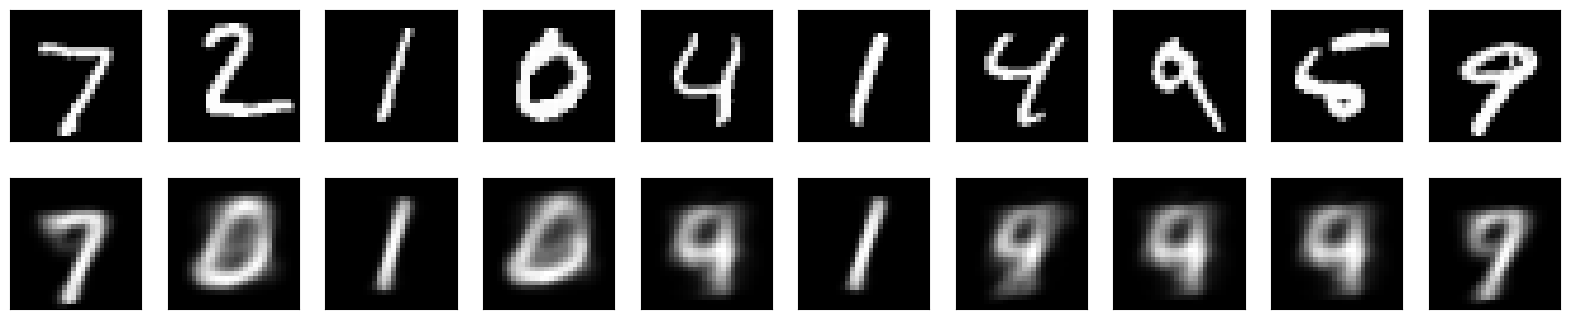

In [ ]:
decoded_imgs = vae.predict(x_test)

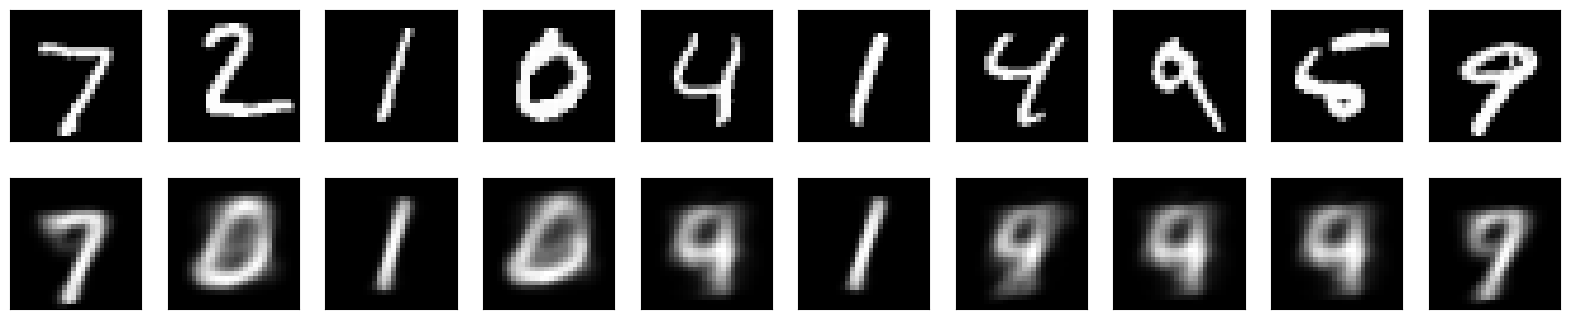

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 設定超參數
learning_rate = 0.001
batch_size = 32
epochs = 10

In [ ]:
# 設定模型架構
input_shape = (28, 28, 1)
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu')
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(128,)),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid')
])

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [128], output_shape = [7, 7, 32]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 128), dtype=float32)